In [2]:
import os
from pathlib import PurePath, Path
import ssl

import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten, concatenate, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

### SSL Certificate for downloading


In [3]:
ssl._create_default_https_context = ssl._create_unverified_context

### Downloading and extracting images dataset


In [4]:
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
data_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url, extract=True)
print(data_dir)

/Users/igor/.keras/datasets/cats_and_dogs_filtered.zip


### Dataset path


In [5]:
data_dir = os.path.join(os.path.dirname(data_dir), 'cats_and_dogs_filtered_merged')
data_dir = Path(data_dir)
print(data_dir)

/Users/igor/.keras/datasets/cats_and_dogs_filtered_merged


### Creating training and validation datasets


In [6]:
img_height,img_width=180,180
batch_size=32
seed=1337
validation_split=0.2

print('=====Testing=====')

train = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  subset="training",
  validation_split=validation_split,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)


print('\r\n=====Validation=====')

val = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  subset="validation",
  validation_split=validation_split,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

=====Testing=====
Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Metal device set to: Apple M1 Pro

=====Validation=====
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


2022-11-15 00:04:16.914530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 00:04:16.914934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Classnames

In [7]:
class_names = train.class_names
print(class_names)

['cats', 'dogs']


### Data view


2022-11-15 00:04:17.059987: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


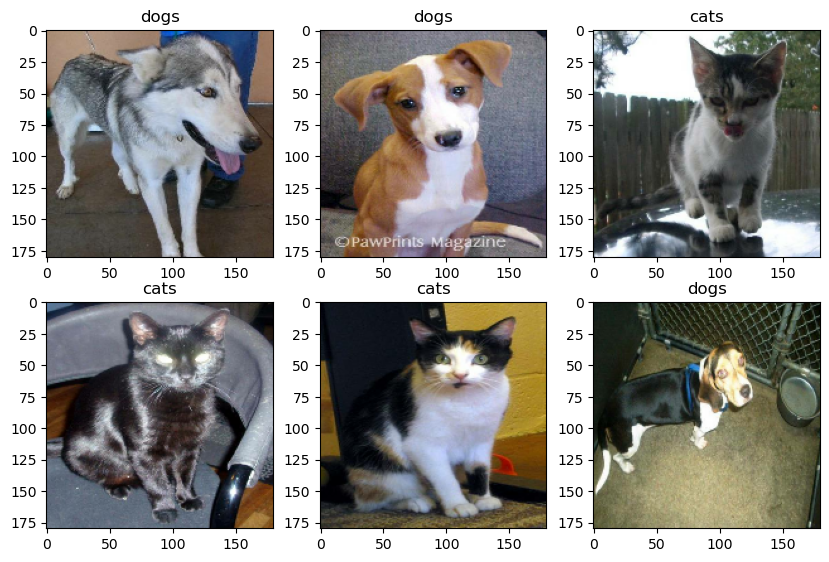

In [8]:
plt.figure(figsize=(10, 10))

# take 1 batch
for images, labels in train.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

### Bulding 2-branch Resnet50 NN


#### Input Layer

In [9]:
input_layer = Input(shape=(180,180,3), dtype=tf.float32)

#### ResNet50 Model 1

In [10]:
ResNet_1=tf.keras.applications.ResNet50(
    input_tensor=input_layer,
    include_top=False,
    input_shape=(180,180,3),
    pooling='avg',
    weights='imagenet',
    classes=2)

  
for layer in ResNet_1.layers:
    layer.trainable=False
    layer._name = layer.name + str('_1')
    
layer_1_1 = ResNet_1.output

layer_2_1 = Flatten()(layer_1_1)
layer_3_1 = Dense(512, activation='relu')(layer_2_1)

model_1 = Model(inputs = input_layer, outputs = layer_2_1)

#### ResNet50 Model 2

In [11]:
ResNet_2=tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(180,180,3),
    pooling='avg',
    weights='imagenet',
    classes=2)

for layer in ResNet_2.layers:
    layer.trainable=False
    layer._name = layer.name + str('_1')
    
layer_1_2 = ResNet_1.output

layer_2_2 = Flatten()(layer_1_2)
layer_3_2 = Dense(512, activation='relu')(layer_2_2)

model_2 = Model(inputs = input_layer, outputs = layer_3_2)

#### Merging both models + output layers

In [12]:
combo = concatenate([model_1.output, model_2.output])

layer_2 = Dense(256, activation='relu')(combo)
layer_3 = Dense(32, activation='relu')(layer_2)

combo_output = Dense(2, activation='sigmoid')(layer_3)

combo_model = Model(inputs = input_layer, outputs = combo_output)

### Training

In [13]:
combo_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#### Plot model

In [14]:
#plot_model(combo_model, show_shapes=True)

#### Model summary

In [15]:
#combo_model.summary()

In [16]:
combo_model_fitted = combo_model.fit(train, validation_data=val, epochs=5)

Epoch 1/5


2022-11-15 00:04:20.587389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9375

2022-11-15 00:04:28.885700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 12s 137ms/step - loss: 0.1745 - accuracy: 0.9375 - val_loss: 0.0890 - val_accuracy: 0.9667
Epoch 2/5
75/75 [==============================] - 10s 126ms/step - loss: 0.0692 - accuracy: 0.9725 - val_loss: 0.0894 - val_accuracy: 0.9667
Epoch 3/5
75/75 [==============================] - 9s 126ms/step - loss: 0.0453 - accuracy: 0.9804 - val_loss: 0.1013 - val_accuracy: 0.9633
Epoch 4/5
75/75 [==============================] - 9s 126ms/step - loss: 0.0292 - accuracy: 0.9888 - val_loss: 0.1111 - val_accuracy: 0.9717
Epoch 5/5
75/75 [==============================] - 9s 125ms/step - loss: 0.0252 - accuracy: 0.9900 - val_loss: 0.1346 - val_accuracy: 0.9600


### Accuracy and Loss fn on training and validation datasets


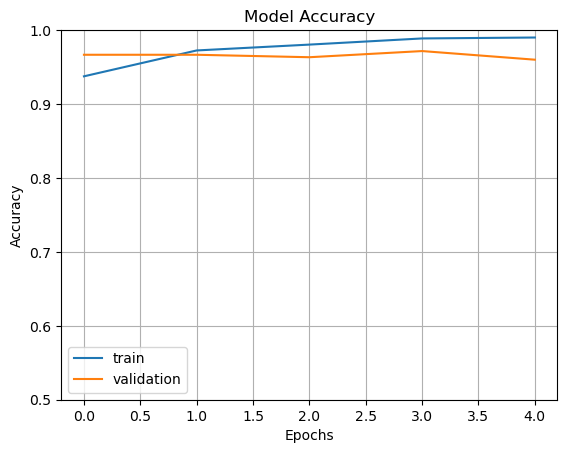

In [17]:
plt.plot(combo_model_fitted.history['accuracy'])
plt.plot(combo_model_fitted.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0.5,ymax=1)
plt.grid()

plt.show()

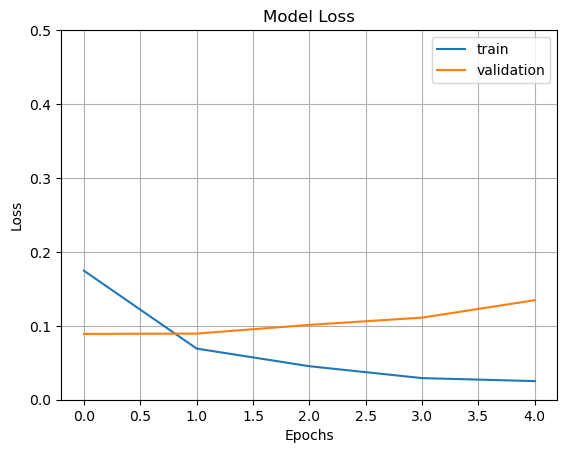

In [18]:
plt.plot(combo_model_fitted.history['loss'])
plt.plot(combo_model_fitted.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0,ymax=0.5)
plt.grid()

plt.show()

### Testing model on custom pictures


In [19]:
test_data_dir=Path(Path().parent.absolute(), 'example_pictures')
example_pictures = sorted(list(test_data_dir.glob('*.jpg')))

1/1 [==============================] - 0s 38ms/step


(-0.5, 449.5, 449.5, -0.5)

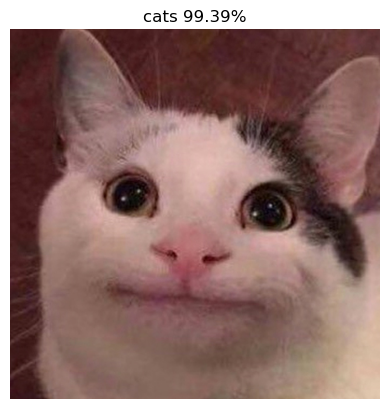

In [34]:
index = 0

#load image
image=cv2.imread(str(example_pictures[index]))
#resize image
image_resized= cv2.resize(image, (img_height,img_width))
#expand dimensions
expanded_image=np.expand_dims(image_resized,axis=0)

pred=np.squeeze(combo_model.predict(expanded_image))
confidence = pred[np.argmax(pred)] * 100
output_class=class_names[np.argmax(pred)]

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'{output_class} {str(round(confidence, 2))}%');
plt.axis("off")
